In [21]:
import pandas as pd
import numpy as np
import tqdm
import json
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import collections
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

### Load data

In [2]:
#recipes
cleaned_recipes = json.load(open("./../generated/high_score_repr_recipes.json"))

#mapping
ing_mapping = json.load(open("./../generated/ing_usda_mapping_high_score.json"))

#group description
columns = ["food_group_id", "food_group_name"]
food_groups = pd.read_csv("./../data/usda/FD_GROUP.txt", sep="^", encoding="ISO-8859-1", names=columns, header=None)

#id mapping
columns = ["food_id", "food_group_id"]
use_cols = [0, 1]
food_des = pd.read_csv("./../data/usda/FOOD_DES.txt", sep="^", encoding="ISO-8859-1", names=columns, usecols=use_cols, header=None)

### Create food groups dictionnaries

In [3]:
#useful ids
usda_ids = [ing_mapping[ing]for ing in ing_mapping]

#matching ids dict
ids_dict = dict()
for usda_id in usda_ids :
    matching_group = int(food_des[food_des["food_id"] == usda_id]['food_group_id'].values[0])
    ids_dict[usda_id] = matching_group
    
json.dump(ids_dict, open("./../generated/food_to_group_high_score.json", 'w'))

#food groups description ids
group_des = dict()
for entry in food_groups.values :
    group_des[entry[0]] = entry[1]

json.dump(group_des, open("./../generated/group_des.json", 'w'))

### generate recipe's food groups vectors

In [4]:

food_groups_index = sorted(food_groups['food_group_id'])
food_groups_names = [group_des[fg_id] for fg_id in food_groups_index]

def recipe_to_ids(recipe) : return [int(ing[8:]) for ing in recipe if ing[:8] == 'usda_id=']
          
def ids_to_food_groups(ids) : return [ids_dict[i] for i in ids]

def food_groups_to_vector(food_groups) :
    count_vector = [0]*len(food_groups_index)
    for fg_id in food_groups :
        count_vector[food_groups_index.index(fg_id)] += 1
        
    return count_vector

def recipe_to_vector(recipe) : return food_groups_to_vector(ids_to_food_groups(recipe_to_ids(recipe)))    


#generate all vectors
vectors_recipes = []
for r in tqdm.tqdm(cleaned_recipes) :
    vector = recipe_to_vector(r)
    if sum(vector) != 0 :
        vectors_recipes.append(vector)
    
#translate to np array now that the append phase is over
vectors_recipes = np.array(vectors_recipes)    

100%|██████████| 96529/96529 [00:00<00:00, 138811.80it/s]


## vectors study

#### basic statistics

First, what are the numbers of ingredients in the recipes ?

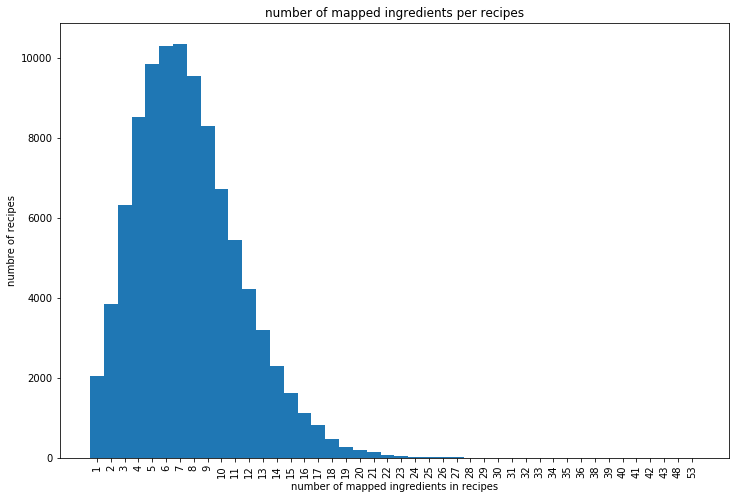

In [5]:
t = collections.Counter()
t.update([sum(vec) for vec in vectors_recipes])
t.most_common()

labels, values = zip(*sorted(t.items()))

indexes = np.arange(len(labels))
width = 1

plt.rcParams["figure.figsize"] = [12, 8]
plt.bar(indexes, values, width)
plt.xticks(indexes, labels, rotation=90)
plt.title("number of mapped ingredients per recipes")
plt.xlabel("number of mapped ingredients in recipes")
plt.ylabel("numbre of recipes")
plt.show()

> we see that the main number of ingredients per recipes is 6 or 7. What types of ingredients are they (i.e., of which food group) ?

In [6]:
sorted([c for c in zip(vectors_recipes.sum(axis=0), food_groups_names)], key= lambda x : x[0])

[(547, 'Breakfast Cereals'),
 (1064, 'Restaurant Foods'),
 (1111, 'Baby Foods'),
 (1334, 'Lamb, Veal, and Game Products'),
 (1621, 'Meals, Entrees, and Side Dishes'),
 (1781, 'Fast Foods'),
 (2851, 'American Indian/Alaska Native Foods'),
 (3045, 'Finfish and Shellfish Products'),
 (3753, 'Poultry Products'),
 (3753, 'Beef Products'),
 (4067, 'Pork Products'),
 (6859, 'Snacks'),
 (10657, 'Nut and Seed Products'),
 (11018, 'Sausages and Luncheon Meats'),
 (23411, 'Legumes and Legume Products'),
 (25105, 'Soups, Sauces, and Gravies'),
 (29199, 'Beverages'),
 (31180, 'Cereal Grains and Pasta'),
 (31381, 'Baked Products'),
 (36060, 'Sweets'),
 (37571, 'Fruits and Fruit Juices'),
 (53487, 'Fats and Oils'),
 (99070, 'Dairy and Egg Products'),
 (145332, 'Spices and Herbs'),
 (169324, 'Vegetables and Vegetable Products')]

> As expected, the spices and the vegetables are the most common ingredients used. We notice that the snacks have been used a lot which is rather surprising.

Now, what is the mean recipe composition ?

In [7]:
mean_ings = sorted([c for c in zip(vectors_recipes.mean(axis=0), food_groups_names)], key= lambda x : x[0])
print("mean number of ingredients : ", sum([c[0] for c in mean_ings]))
mean_ings

mean number of ingredients :  7.646548762842599


[(0.005693942769109059, 'Breakfast Cereals'),
 (0.011075603485067713, 'Restaurant Foods'),
 (0.011564845368336681, 'Baby Foods'),
 (0.013886141963421363, 'Lamb, Veal, and Game Products'),
 (0.016873640271893576, 'Meals, Entrees, and Side Dishes'),
 (0.018539144555362402, 'Fast Foods'),
 (0.0296772044510602, 'American Indian/Alaska Native Foods'),
 (0.031696628394766155, 'Finfish and Shellfish Products'),
 (0.03906648484911572, 'Poultry Products'),
 (0.03906648484911572, 'Beef Products'),
 (0.0423350370054233, 'Pork Products'),
 (0.07139808675195436, 'Snacks'),
 (0.11093299468079569, 'Nut and Seed Products'),
 (0.11469078872037224, 'Sausages and Luncheon Meats'),
 (0.24369450487680472, 'Legumes and Legume Products'),
 (0.26132803147803096, 'Soups, Sauces, and Gravies'),
 (0.30394412233128965, 'Beverages'),
 (0.32456514724098806, 'Cereal Grains and Pasta'),
 (0.32665743699709576, 'Baked Products'),
 (0.3753630278867873, 'Sweets'),
 (0.3910916339637961, 'Fruits and Fruit Juices'),
 (0.556

We find again the mean number of ingredients. Let's standardize it to get the probability of each ingredient (by log likelihood, independence assumption)

In [12]:
sorted([c for c in zip(vectors_recipes.mean(axis=0) / sum(vectors_recipes.mean(axis=0)), food_groups_names)], key = lambda x : x[0])

[(0.0007446421837755129, 'Breakfast Cereals'),
 (0.0014484447596657146, 'Restaurant Foods'),
 (0.0015124268120193692, 'Baby Foods'),
 (0.001816001230633518, 'Lamb, Veal, and Game Products'),
 (0.002206700146069665, 'Meals, Entrees, and Side Dishes'),
 (0.002424511388124659, 'Fast Foods'),
 (0.003881124069367436, 'American Indian/Alaska Native Foods'),
 (0.004145220200359117, 'Finfish and Shellfish Products'),
 (0.005109034946452469, 'Poultry Products'),
 (0.005109034946452469, 'Beef Products'),
 (0.005536489508985396, 'Pork Products'),
 (0.009337295682845052, 'Snacks'),
 (0.014507590041125487, 'Nut and Seed Products'),
 (0.014999026656012068, 'Sausages and Luncheon Meats'),
 (0.03186986867343425, 'Legumes and Legume Products'),
 (0.03417594519869151, 'Soups, Sauces, and Gravies'),
 (0.039749190354773686, 'Beverages'),
 (0.04244596579546708, 'Cereal Grains and Pasta'),
 (0.04271959116829867, 'Baked Products'),
 (0.04908920867814442, 'Sweets'),
 (0.051146163595301275, 'Fruits and Fruit J

Those results are interesting but we agglomerate all the recipes together and lose the ability to distinguish some recipes categories. We now try to discover hidden recipe compositions patterns by clustering the recipes.

#### clustering

  0%|          | 0/5 [00:00<?, ?it/s]

For n_clusters = 2 The average silhouette_score is : 0.23564934965620912


 20%|██        | 1/5 [01:05<04:20, 65.14s/it]

For n_clusters = 3 The average silhouette_score is : 0.2178509972334275


 40%|████      | 2/5 [02:12<03:17, 65.72s/it]

For n_clusters = 4 The average silhouette_score is : 0.1660304653517712


 60%|██████    | 3/5 [03:19<02:12, 66.18s/it]

For n_clusters = 5 The average silhouette_score is : 0.1630317053553047


 80%|████████  | 4/5 [04:30<01:07, 67.72s/it]

For n_clusters = 6 The average silhouette_score is : 0.13362862473703635


100%|██████████| 5/5 [05:42<00:00, 68.89s/it]


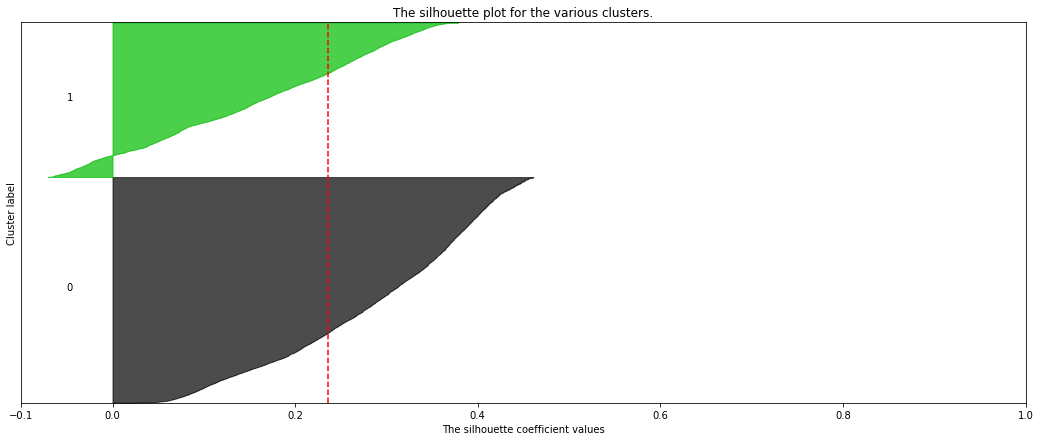

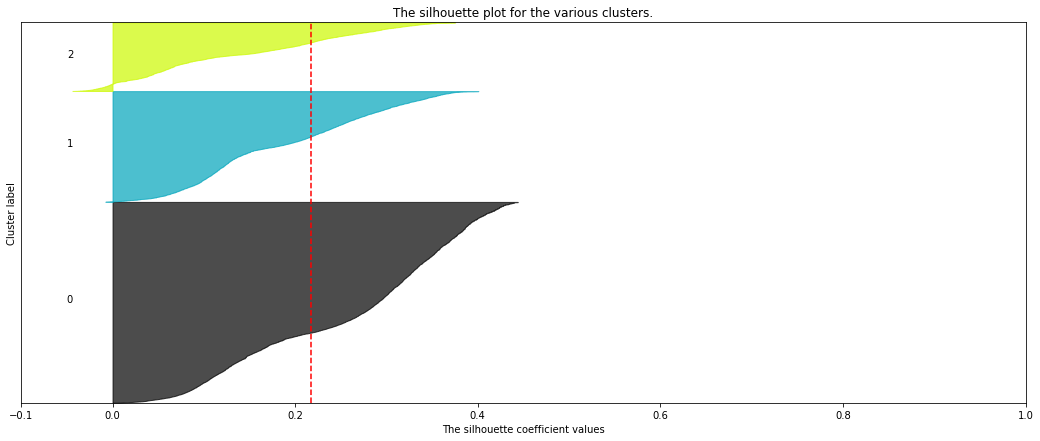

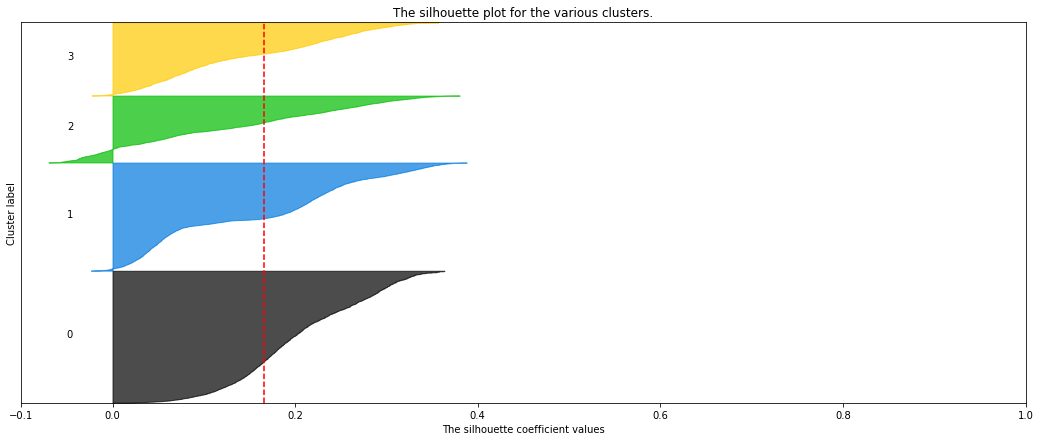

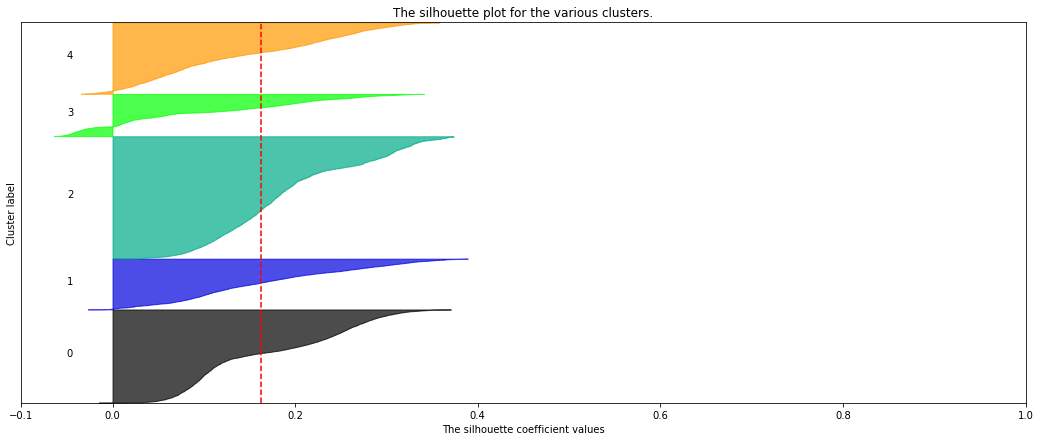

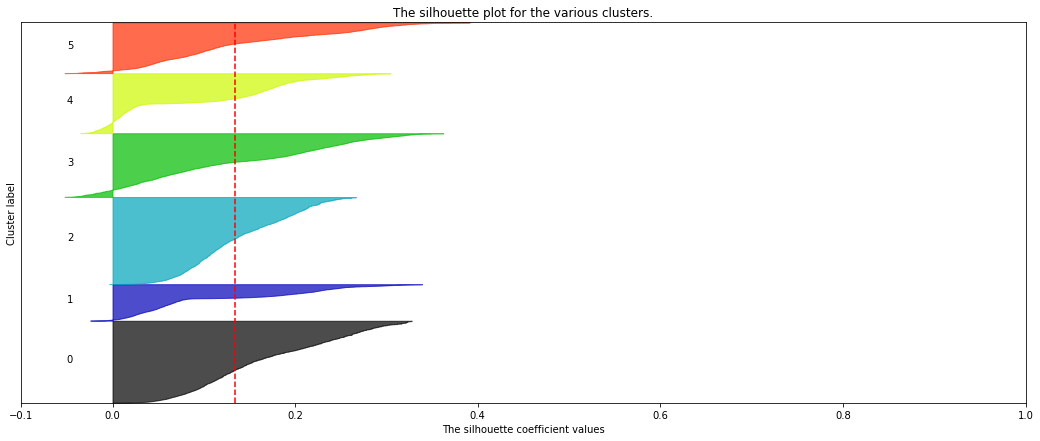

In [27]:
range_n_clusters = [2, 3, 4, 5, 6]

X = np.array(vectors_recipes.copy()[:30000])

for n_clusters in tqdm.tqdm(range_n_clusters):
    # Create a subplot with 1 row and 2 columns
    fig, ax1 = plt.subplots()
    fig.set_size_inches(18, 7)

    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

plt.show()